# Data exploration and preprocessing

- In this notebook, we load in the MRI scans and their segmentations, build a Dataset object for the train and test set.
- Then we check some basic stats of the datasets and visualise a few scans.
- Finally, we carry out our preprocessing steps and save the train and test datasets.

In [19]:
%load_ext autoreload
%autoreload 2

import os
import logging
from glob import glob
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_utils import Dataset

# get TF logger - set it to info for more tracking process
log = logging.getLogger('tensorflow')
log.setLevel(logging.WARNING)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create train and test datasets

Find all the raw data files and build train and test Dataset objects from the patients' scans. 

In [20]:
# get file paths to DICOM MRI and segmentation images, note that leaderboard samples can be used for training
train_scan_files = glob('../data/raw/train/**/*.dcm', recursive=True)
train_scan_files += glob('../data/raw/leaderboard/**/*.dcm', recursive=True)
test_scan_files = glob('../data/raw/test/**/*.dcm', recursive=True)

# ProstateDx-01-0006_corrected_label.nrrd was renamed to ProstateDx-01-0006.nrrd
# In the leaderboard and test folders the _truth postfix have been removed from all nrrd files
train_seg_files = glob('../data/raw/train/**/*.nrrd', recursive=True)
train_seg_files += glob('../data/raw/leaderboard/**/*.nrrd', recursive=True)
test_seg_files = glob('../data/raw/test/**/*.nrrd', recursive=True)

# build datasets from file paths
train_dataset = Dataset(scan_files=train_scan_files, seg_files=train_seg_files)
test_dataset = Dataset(scan_files=test_scan_files, seg_files=test_seg_files)

## Check basic stats
Check number of patients in train and test datasets.

In [21]:
train_n = len(train_dataset.patient_ids)
test_n = len(test_dataset.patient_ids)
train_scan_nums = [train_dataset.patients[p].scans.shape[0] for p in train_dataset.patient_ids]
test_scan_nums = [test_dataset.patients[p].scans.shape[0] for p in test_dataset.patient_ids]

print('Number of patients in train dataset: %d' % train_n)
print('Number of patients in test dataset: %d' % test_n)
print('Number of scans in train dataset: %d' % sum(train_scan_nums))
print('Number of scans in test dataset: %d' % sum(test_scan_nums))

Number of patients in train dataset: 70
Number of patients in test dataset: 10
Number of scans in train dataset: 1816
Number of scans in test dataset: 271


Check distribution of number of scans in train and test datasets.
- They both seem bi-modal with roughly the same peaks. 

(array([5., 0., 0., 0., 0., 0., 1., 3., 0., 1.]),
 array([19. , 21.1, 23.2, 25.3, 27.4, 29.5, 31.6, 33.7, 35.8, 37.9, 40. ]),
 <a list of 10 Patch objects>)

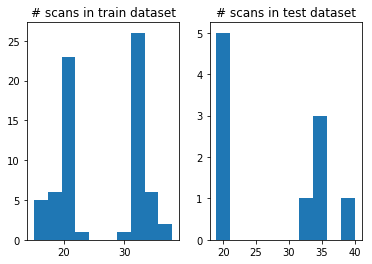

In [22]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('# scans in train dataset')
ax[0].hist(train_scan_nums, bins=10)
ax[1].set_title('# scans in test dataset')
ax[1].hist(test_scan_nums, bins=10)

Make sure that none of the patients have scans from mixed manufacturers and with mixed slice thickness.

In [23]:
# extract manufacturer and thickness sets from each patient
train_manufacturers = [train_dataset.patients[p].manufacturers for p in train_dataset.patient_ids]
train_thicknesses = [train_dataset.patients[p].thicknesses for p in train_dataset.patient_ids]
test_manufacturers = [test_dataset.patients[p].manufacturers for p in test_dataset.patient_ids]
test_thicknesses = [test_dataset.patients[p].thicknesses for p in test_dataset.patient_ids]

# check if any patient has slices from two different manufacturers or thicknesses - NO
for m in train_manufacturers + test_manufacturers:
    assert len(m) == 1

for t in train_thicknesses + test_thicknesses:
    assert len(t) == 1

### Create summary table 

Collate all information into a pandas DataFrame from the datasets so we can analyse it easily later.

In [24]:
# collapse all list of sets to simple list
train_manufacturers = [list(i)[0] for i in train_manufacturers]
train_thicknesses = [list(i)[0] for i in train_thicknesses]
test_manufacturers = [list(i)[0] for i in test_manufacturers]
test_thicknesses = [list(i)[0] for i in test_thicknesses]

# extract scan width, height and max value
train_widths = [train_dataset.patients[p].scans.shape[1] for p in train_dataset.patient_ids]
train_heights = [train_dataset.patients[p].scans.shape[2] for p in train_dataset.patient_ids]
train_max = [train_dataset.patients[p].scans.max() for p in train_dataset.patient_ids]
test_widths = [test_dataset.patients[p].scans.shape[1] for p in test_dataset.patient_ids]
test_heights = [test_dataset.patients[p].scans.shape[2] for p in test_dataset.patient_ids]
test_max = [test_dataset.patients[p].scans.max() for p in test_dataset.patient_ids]

# calculate contingency table from them
df_summary = pd.DataFrame(
    list(
        zip(
            train_dataset.patient_ids + test_dataset.patient_ids,
            train_manufacturers + test_manufacturers,
            train_thicknesses + test_thicknesses,
            train_widths + test_widths,
            train_heights + test_heights,
            train_max + test_max,
            train_scan_nums + test_scan_nums,
            ['train'] * train_n + ['test'] * test_n
        )
    ), 
    columns = ['patient_id', 'manufacturer', 'thickness', 'width', 'heigth', 'max_val', 'scan_num', 'dataset']
)

- Looks like the test and train datasets have been properly stratified with respect to manufacturer, i.e. half of the sample are from Siemens and half of them are from Philips.
- However, the test dataset doesn't have slices of 4mm thickness.

In [25]:
df_summary.drop(
    ['width', 'heigth', 'scan_num', 'max_val'], axis=1
).groupby(
    ['dataset', 'manufacturer', 'thickness']
).count()

patient_id
dataset manufacturer            thickness            
test    Philips Medical Systems 3                   5
        SIEMENS                 3                   5
train   Philips Medical Systems 3                  35
        SIEMENS                 3                  29
                                4                   6

- Philips is the higher resolution machine, all scans are rectangular.

In [26]:
df_summary.drop(
    ['thickness', 'max_val', 'scan_num'], axis=1
).groupby(
    ['dataset', 'manufacturer', 'width', 'heigth']
).count()

patient_id
dataset manufacturer            width heigth            
test    Philips Medical Systems 400   400              5
        SIEMENS                 384   384              5
train   Philips Medical Systems 400   400             33
                                432   432              1
                                512   512              1
        SIEMENS                 256   256              1
                                320   320             29
                                384   384              5

- There's a large variation in the scans' maximum values and there are some clear outliers too (Siemens scan with max=65283, coming from the 18th scan of patient Prostate3T-01-0018)

In [27]:
df_summary.drop(
    ['thickness', 'patient_id', 'scan_num'], axis=1
).groupby(
    ['dataset', 'manufacturer', 'width', 'heigth']
).agg(['min', 'max', 'mean'])

max_val                    
                                                 min    max         mean
dataset manufacturer            width heigth                            
test    Philips Medical Systems 400   400        358   1267   774.800000
        SIEMENS                 384   384        985   1148  1048.400000
train   Philips Medical Systems 400   400        194   1198   468.060606
                                432   432        220    220   220.000000
                                512   512        850    850   850.000000
        SIEMENS                 256   256       1816   1816  1816.000000
                                320   320       1155  65283  3952.137931
                                384   384       1024   1405  1158.800000

- Here's the reason for those bi-modal histograms above, Philips mave higher number of scans on average.

In [28]:
df_summary.drop(
    ['thickness', 'max_val', 'width', 'heigth', 'patient_id'], axis=1
).groupby(
    ['dataset', 'manufacturer']
).agg(['min', 'max', 'median'])

scan_num           
                                     min max median
dataset manufacturer                               
test    Philips Medical Systems       32  40     34
        SIEMENS                       19  21     19
train   Philips Medical Systems       30  38     32
        SIEMENS                       15  24     20

## Visualise scans

Each patient's scans can be viewed as an animation or as a tiled figure. Let's have a look at some of these.

**Note** you'll need to re-execute the cell to watch the animation.

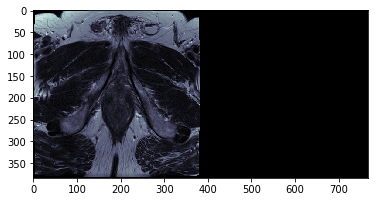

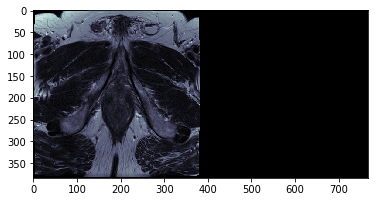

In [29]:
# animation
patient_id = train_dataset.patient_ids[23]
train_dataset.patients[patient_id].anim_scans()

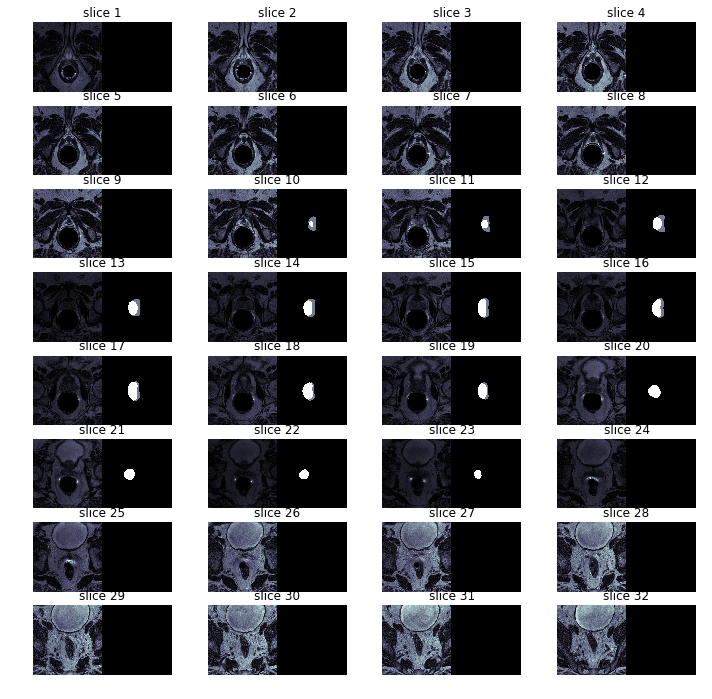

In [30]:
# tiled figure
patient_id = train_dataset.patient_ids[2]
train_dataset.patients[patient_id].show_scans()

## Preprocess data

As we've seen from the summary stats above the scans are non-normalised and span a wide range of maximal values, resolution and number of scans. 

The `preprocess_dataset` method:
  - normalises the scans to be between zero and one
  - resizes each scan and target segmentation image to the same width and height
    - since 3D U-Net is fully convolutional, this isn't needed necessarily but it reduces the required memory at training time
  - unifies the depth, i.e. the number of scans across the patients (eithe 24 or 32)
    - this ensures that with a 4 layer deep 3D U-Net we'll get matching dimensions when we concatenate the shurtcuts in the network 




In [31]:
train_dataset.preprocess_dataset(width=128, height=128, depths=(24, 32))
test_dataset.preprocess_dataset(width=128, height=128, depths=(24, 32))

Let's check if the scans and targets still look reasonable on the previous tiled example.

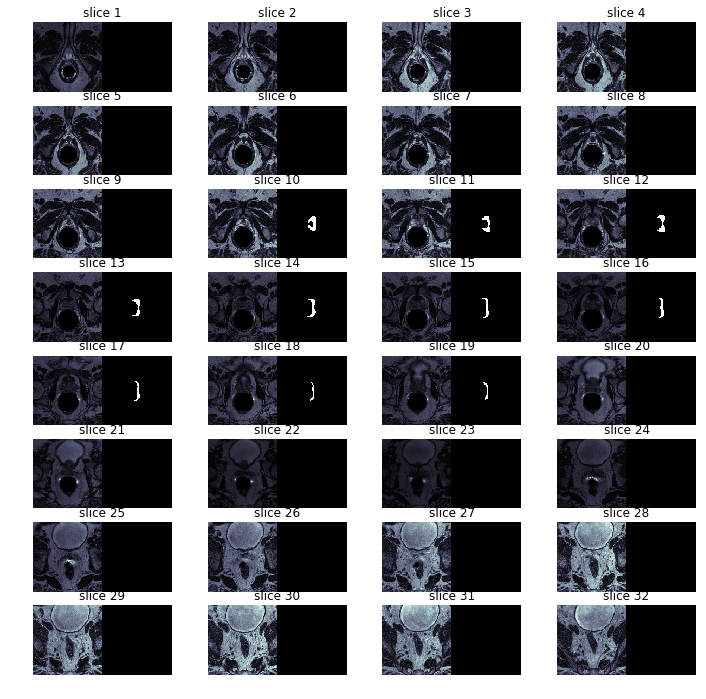

In [32]:
# note the target is now a one-hot tensor, so we only show the 2nd class
patient_id = train_dataset.patient_ids[2]
train_dataset.patients[patient_id].show_scans()

Finally, let's check that the preprocessing worked for all images. Specifically we should find that:
- the number of scans are either 24 or 32 for all patients
- the resolution is 128 by 128 
- the maximum value of the scans is less than or equal to 1
- the corresponding target tensor has an extra dimension, corresponding to the one hot encoding of the 3 classes

In [33]:
datasets = [train_dataset, test_dataset]
for dataset in datasets:
    for i in range(len(dataset.patients.keys())):
        patient_id = dataset.patient_ids[i]
        scans = dataset.patients[patient_id].scans 
        seg = dataset.patients[patient_id].seg

        assert(scans.shape[1:] == (128, 128))
        assert(scans.shape[0] in (24, 32))
        assert(scans.max() <= 1)

        assert(seg.shape[1:3] == (128, 128))
        assert(seg.shape[0] in (24, 32))
        assert(seg.shape[3] == 3)

## Calculate class frequency

The 3 classes are imbalanced, calculate their frequency in the data. This will inform our weighting scheme that we use with the loss function at training time.

In [34]:
class_freq = np.zeros(3)
for dataset in datasets:
    for i in range(len(dataset.patients.keys())):
        patient_id = dataset.patient_ids[i]
        seg = dataset.patients[patient_id].seg
        class_freq += seg.sum(axis=(0, 1, 2))
class_freq = class_freq / class_freq.sum()
inv_class_freq = 1/class_freq
norm_inv_class_freq = inv_class_freq / inv_class_freq.sum()
norm_inv_class_freq

array([0.00408978, 0.70013423, 0.295776  ])

## Save the datasets

We save them as pickled objects so we can use them later for training and model evaluation.

In [36]:
train_dataset.save_dataset('../data/processed/train_dataset.pckl')
test_dataset.save_dataset('../data/processed/test_dataset.pckl')